In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf 
import pandas as pd
import json
import sys,os
sys.path.append(os.path.realpath('../..'))

import pickle
# from core.losses import custom_rmse
from core.classifier import predict_from_path
from core.data  import clf_records, pretraining_records
from core.astromer import get_ASTROMER
from sklearn.metrics import confusion_matrix, accuracy_score
from core.plots import plot_cm

%load_ext autoreload
%autoreload 2

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Helvetica"]})
# # for Palatino and other serif fonts use:
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })

In [3]:
data_folder = '../../data/records/alcock'
pretrained_model = '../../weights/astromer_10022021/'

In [4]:
conf_file = os.path.join(pretrained_model, 'conf.json')
with open(conf_file, 'r') as handle:
    conf = json.load(handle)

model = get_ASTROMER(num_layers=conf['layers'],
                     d_model   =conf['head_dim'],
                     num_heads =conf['heads'],
                     dff       =conf['dff'],
                     base      =conf['base'],
                     dropout   =conf['dropout'],
                     maxlen    =conf['max_obs'],
                     use_leak  =conf['use_leak'])

weights_path = '{}/weights'.format(pretrained_model)
model.load_weights(weights_path)

2021-11-08 16:36:15.707210: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-08 16:36:16.122786: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22354 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:81:00.0, compute capability: 8.6


In [5]:
dataset = pretraining_records(os.path.join(data_folder, 'train'),
                                           256,
                                            max_obs=conf['max_obs'],
                                            shuffle=True,
                                            msk_frac=conf['msk_frac'],
                                            rnd_frac=conf['rnd_frac'],
                                            same_frac=conf['same_frac'])

[INFO] Shuffling


In [22]:
def custom_rmse(y_true, y_pred, sample_weight=None, mask=None):
    inp_shp = tf.shape(y_true)
    residuals = tf.square(y_true - y_pred)

    if sample_weight is not None:
        residuals = tf.multiply(residuals, sample_weight)

    if mask is not None:
        residuals = tf.multiply(residuals, mask)
        
    residuals  = tf.reduce_sum(residuals, 1)
    
    
    mse_mean = tf.math.divide_no_nan(residuals,
                         tf.reduce_sum(mask, 1))
        
    mse_mean = tf.reduce_mean(mse_mean)
    return tf.math.sqrt(mse_mean)

In [23]:
for batch in dataset:
    
    x_pred = model(batch)
        
    mse = custom_rmse(y_true=batch['output'],
                     y_pred=x_pred,
                     mask=batch['mask_out'])
    

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/users/cdonoso/miniconda3/envs/tf2/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2820, in while_loop
    return result  File "/home/users/cdonoso/miniconda3/envs/tf2/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2768, in <lambda>
    body = lambda i, lv: (i + 1, orig_body(*lv))  File "/home/users/cdonoso/miniconda3/envs/tf2/lib/python3.8/site-packages/tensorflow/python/ops/map_fn.py", line 499, in compute
    return (i + 1, tas)  File "/home/users/cdonoso/miniconda3/envs/tf2/lib/python3.8/site-packages/tensorflow/python/ops/map_fn.py", line 497, in <listcomp>
    ta.write(i, value) for (ta, value) in zip(tas, result_value_batchable)  File "/home/users/cdonoso/miniconda3/envs/tf2/

In [27]:
rnn_cm = confusion_matrix(rnn_results['y_true'], rnn_results['y_pred'], normalize='true')
fc_att_cm = confusion_matrix(fc_att_results['y_true'], fc_att_results['y_pred'], normalize='true')
rnn_att_cm = confusion_matrix(rnn_att_results['y_true'], rnn_att_results['y_pred'], normalize='true')


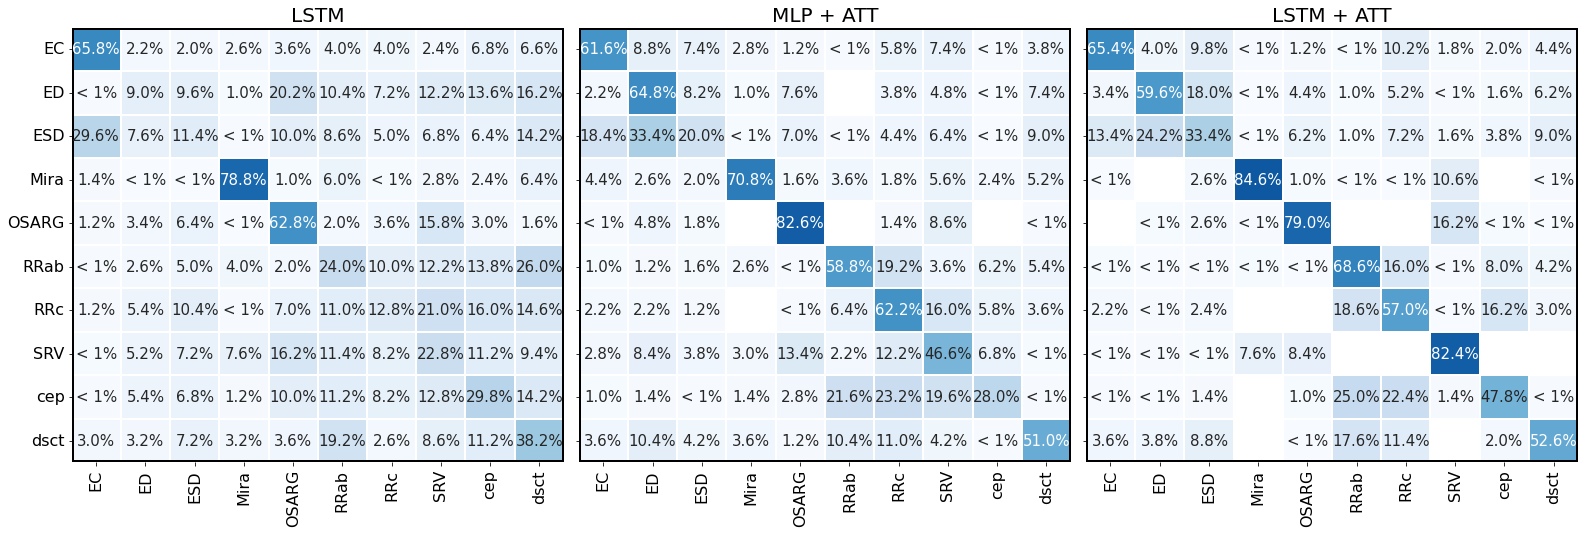

In [28]:
# fig, axes = plt.subplots(1,2, figsize=(18,7), sharey=True, gridspec_kw={'hspace': 0., 'wspace': 0.03})
fig, axes = plt.subplots(1,3, figsize=(27,8), sharey=True, gridspec_kw={'hspace': 0., 'wspace': 0.03})

axes[0] = plot_cm(rnn_cm, axes[0], title='LSTM', class_names=cls_names)
axes[1] = plot_cm(fc_att_cm, axes[1], title='MLP + ATT', class_names=cls_names)
axes[2] = plot_cm(rnn_att_cm, axes[2], title='LSTM + ATT', class_names=cls_names)